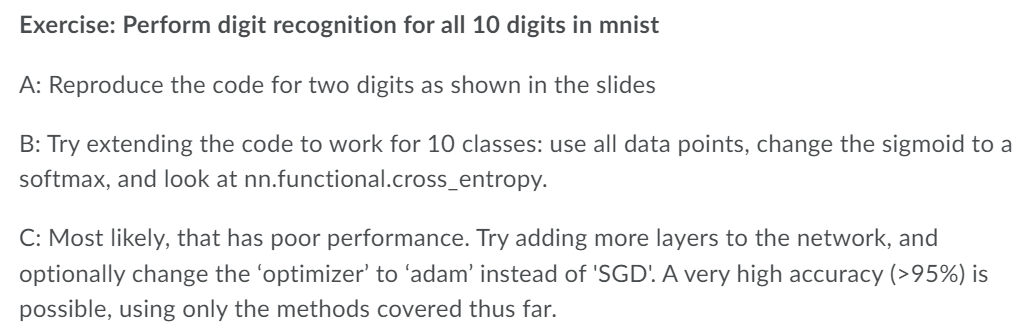

In [1]:
#Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

#Sci-kit learn
import sklearn.model_selection

#Numpy
import numpy as np

#Matplotlib
import matplotlib.pyplot as plt

#Dataset
from mlxtend.data import mnist_data


In [18]:
device = torch.device('cpu')
if torch.cuda.is_available():
    cuda = torch.device('cuda')
    print(torch.version.cuda)
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    t = torch.cuda.get_device_properties(0).total_memory
    print(t/1e6)
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    f = r-a
    print('reserved memory',r)
    print('allocated memory',a)
    print('free memory',f/1e6)
else:
    print('no cuda available')

11.8
0
1
NVIDIA GeForce RTX 4060 Laptop GPU
8585.216
reserved memory 0
allocated memory 0
free memory 0.0


In [29]:
print('current reserved memory: ', torch.cuda.memory_reserved(0))
print('current allocated memory: ', torch.cuda.memory_allocated(0))
print('available CUDA devices: ', torch.cuda.device_count())

current reserved memory:  0
current allocated memory:  0
available CUDA devices:  1


# Part A
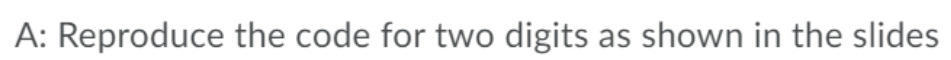

In [3]:
#load handwritten digits data
X,y = mnist_data()

#keep only 0's and 1's for binary classification
keep=(y==0) | (y==1)
X = X[keep,:]
y = y[keep]

In [4]:
#Split data in training and testing sets
Xtrain,Xtest,ytrain,ytest=sklearn.model_selection.train_test_split(X,y,test_size=0.3,shuffle=True)
trainDataset = torch.utils.data.TensorDataset(torch.tensor(Xtrain).float(),torch.tensor(ytrain).float())
testDataset = torch.utils.data.TensorDataset(torch.tensor(Xtest).float(),torch.tensor(ytest).float())

M,N = Xtrain.shape
print('Xtrain shape [M,N]:',[M,N])

Xtrain shape [M,N]: [700, 784]


In [5]:
#Making a neural network
class logRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.inputLayer=nn.Linear(784,1, bias=True)
    def forward(self,x):
        x = self.inputLayer(x)
        x = torch.sigmoid(x)
        return torch.squeeze(x)


In [6]:
#quickly test network
#testData = torch.rand((20,784))
#testNet = logRegression()
#testNet.forward(testData)

In [44]:
#Setup training of network
nEpochs = 100
learningRate = 0.001
batchSize = 64

trainDataLoader = torch.utils.data.DataLoader(trainDataset,batch_size=batchSize,shuffle=True)
model = logRegression()
model.to(cuda)
optimizer = torch.optim.SGD(model.parameters(),learningRate)

loss_fn = nn.BCELoss()

accuracy = np.zeros(nEpochs)

for iEpoch in range(nEpochs):
    estimatedLabels = np.empty((0,))
    trueLabels = np.empty((0,))
    for xbatch, ybatch in trainDataLoader:
        xbatch = xbatch.to(cuda)
        ybatch = ybatch.to(cuda)
        y_pred = model(xbatch)
        loss = loss_fn(y_pred,ybatch)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        yhat=y_pred>0.5
        estimatedLabels = np.append(estimatedLabels,torch.Tensor.cpu(yhat))
        trueLabels = np.append(trueLabels,torch.Tensor.cpu(ybatch))
    accuracy[iEpoch] = np.mean(estimatedLabels==trueLabels)

In [21]:
print('accuracy: \n',accuracy)

accuracy: 
 [0.91714286 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143 0.99857143
 0.99857143 0.99857143 0.99857143 0.99857143 0.998

# Part B
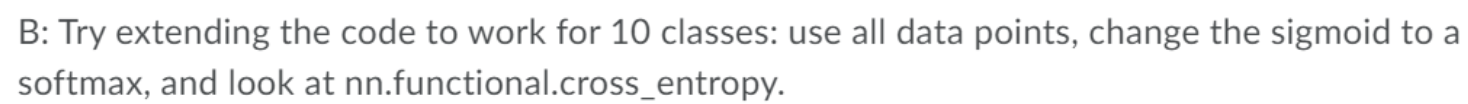